In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [11]:
# Load CSV file
csv_path = 'archive\dogs.csv'
df = pd.read_csv(csv_path)
selected_breeds = ['Afghan','Border Collie','Corgi', 'Doberman', 'German Sheperd', 'Labradoodle', 'Rottweiler', 'Shiba Inu','Shih-Tzu', 'Siberian Husky']

train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'valid']
test_df = df[df['data set'] == 'test']

train_df = train_df[train_df['labels'].isin(selected_breeds)]
valid_df = valid_df[valid_df['labels'].isin(selected_breeds)]
test_df = test_df[test_df['labels'].isin(selected_breeds)]

In [12]:
img_size = (224, 224)
batch_size = 32

# Create image data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='archive/',
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='archive/',
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='archive/',
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 1141 validated image filenames belonging to 10 classes.
Found 100 validated image filenames belonging to 10 classes.
Found 100 validated image filenames belonging to 10 classes.


In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20
)

Epoch 1/20
36/36 [==============================] - 8s 199ms/step - loss: 1.3752 - accuracy: 0.4996 - val_loss: 0.7667 - val_accuracy: 0.8000
Epoch 2/20
36/36 [==============================] - 6s 174ms/step - loss: 1.2000 - accuracy: 0.6004 - val_loss: 0.7070 - val_accuracy: 0.7900
Epoch 3/20
36/36 [==============================] - 6s 171ms/step - loss: 1.0939 - accuracy: 0.6144 - val_loss: 0.5645 - val_accuracy: 0.8800
Epoch 4/20
36/36 [==============================] - 6s 167ms/step - loss: 0.9263 - accuracy: 0.6897 - val_loss: 0.4305 - val_accuracy: 0.8800
Epoch 5/20
36/36 [==============================] - 6s 165ms/step - loss: 0.8298 - accuracy: 0.7204 - val_loss: 0.4091 - val_accuracy: 0.8700
Epoch 6/20
36/36 [==============================] - 6s 168ms/step - loss: 0.8033 - accuracy: 0.7230 - val_loss: 0.4336 - val_accuracy: 0.8600
Epoch 7/20
36/36 [==============================] - 6s 169ms/step - loss: 0.7163 - accuracy: 0.7309 - val_loss: 0.3838 - val_accuracy: 0.8700
Epoch 

In [20]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

4/4 [==============================] - 0s 51ms/step - loss: 0.1927 - accuracy: 0.9500
Test Accuracy: 0.949999988079071


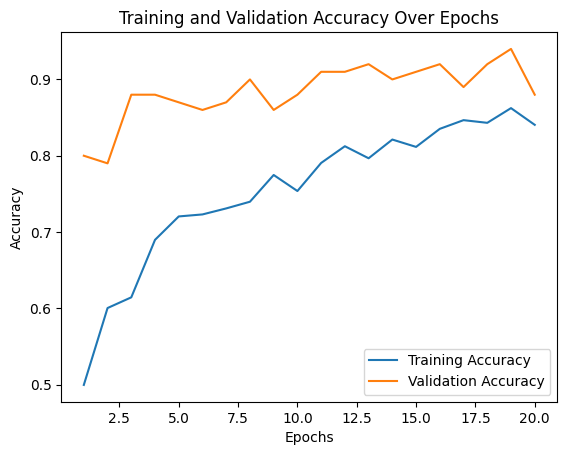

In [22]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy over epochs
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

img_path = 'archive\\test\Border Collie\\01.jpg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


In [43]:
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = train_generator.class_indices
predicted_class_label = [k for k, v in class_labels.items() if v == predicted_class_index][0]



1/1 [==============================] - 0s 14ms/step


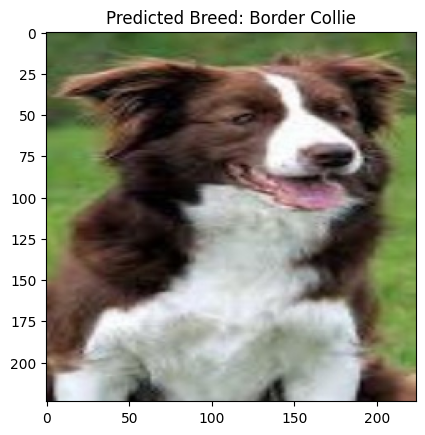

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f'Predicted Breed: {predicted_class_label}')
plt.show()
